In [1]:
library(patchwork)
library(tidyverse)
library(circlize)
library(ggpubr)
library(ggplot2)
library(dplyr)
library(scales)
library(Seurat)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'circlize' was built under R version 4.3.1"
circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(lib

# Load data

In [2]:
metadata <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/s1014_metadata_X_noM_noXistneg.csv") %>% column_to_rownames("...1")
metadata %>% filter(cellname == "d3A74")

New names:
* `` -> `...1`
Rows: 904 Columns: 18
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (7): ...1, orig.ident, sample2, sample3, cellcycle_threshold, day, cell...
dbl (11): nCount_RNA, nFeature_RNA, nCount_SCT, nFeature_SCT, SCT_snn_res.1....

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


,orig.ident,nCount_RNA,nFeature_RNA,sample2,sample3,cellcycle_threshold,day,nCount_SCT,nFeature_SCT,SCT_snn_res.1.5,seurat_clusters,plot_cluster,SCT_snn_res.1,pseudotime_monocle3,curve1,curve2,cellname
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
d3A74,SeuratProject,397,140,s1207,others,G1,d3,424,135,0,0,4,0,11.79871,29.70739,NA,d3A74


In [3]:
mask <- read_csv('/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/fig3/prepare/mask_snp_pos.csv')

Rows: 8552 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): type, type2
dbl (1): pos

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
DI_C5_XCI <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c5_B6_XCI_diff.csv") %>% filter(FDR<0.05) %>% select(-"...1")
DI_C5_XCI <- DI_C5_XCI %>% mutate(ID = paste0(index1, "_", index2))
DI_C0_AS <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/res/c0_B6_Cast_allele_diff.csv") %>% filter(FDR<0.05) %>% select(-"...1")
DI_C0_AS <- DI_C0_AS %>% mutate(ID = paste0(index1, "_", index2))

New names:
* `` -> `...1`
Rows: 1690500 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
* `` -> `...1`
Rows: 1690500 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): chrom1, chrom2
dbl (10): ...1, start1, end1, start2, end2, stats, FDR, index1, index2, p_diff

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
dim(DI_C5_XCI)

[1] 410626     12

In [7]:
dim(metadata %>% filter(plot_cluster == 5))
N <- dim(metadata %>% filter(plot_cluster == 5))[1]

[1] 153  17

In [8]:
N

[1] 153

# Filter decreased DI in XCI

In [13]:
DI_C5_XCI %>% filter(stats < 153*153/2) %>% dim()

[1] 188991     12

In [12]:
DI_dec <- DI_C5_XCI %>% filter(stats < N*N/2) %>% arrange(p_diff) %>% head(0.25*188991)

In [14]:
dim(DI_dec)

[1] 47247    12

In [15]:
DI_dec_pos_count <- DI_dec %>% select(index1) %>% rename(index = index1) %>% rbind(DI_dec %>% select(index2) %>% rename(index = index2)) %>%
    group_by(index) %>% summarise(count = n())

In [16]:
min_index <- min(DI_dec_pos_count$index)
max_index <- max(DI_dec_pos_count$index)
index_add <- data.frame(index = seq(min_index, max_index))

merged_df <- merge(index_add, DI_dec_pos_count, by = "index", all = TRUE)

merged_df$count[is.na(merged_df$count)] <- 0
merged_df$pos_mb <- merged_df$index * 20000 / 1000000

In [17]:
head(merged_df)

,index,count,pos_mb
,<int>,<dbl>,<dbl>
1,277,2,5.54
2,278,1,5.56
3,279,1,5.58
4,280,9,5.60
5,281,3,5.62
6,282,2,5.64


In [18]:
DI_dec_pos_count <- DI_dec_pos_count %>% mutate(pos_mb = index * 20000 / 1000000)

In [19]:
DI_dec_pos_count <- DI_dec_pos_count %>% filter(!((pos_mb > 120)&(pos_mb < 130)))

In [20]:
dim(DI_dec_pos_count)

[1] 5317    3

In [21]:
DI_dec_pos_count <- DI_dec_pos_count %>% merge(merged_df %>% filter(pos_mb > 60) %>% filter(pos_mb < 80), all = TRUE)

In [22]:
DI_dec_pos_count <- DI_dec_pos_count %>% mutate(pos_diff = c(0, diff(pos_mb)))

sub_dfs <- list()
start_idx <- 1

for (idx in 1:nrow(DI_dec_pos_count)) {
  if (DI_dec_pos_count$pos_diff[idx] >= 0.75) {
    sub_dfs[[length(sub_dfs) + 1]] <- DI_dec_pos_count[start_idx:(idx-1), ]
    start_idx <- idx
  }
}
sub_dfs[[length(sub_dfs) + 1]] <- DI_dec_pos_count[start_idx:nrow(DI_dec_pos_count), ]

plot_list <- list()

for (i in seq_along(sub_dfs)) {
  sub_df <- sub_dfs[[i]]
  
  if (nrow(sub_df) >= 2000) {
    filtered <- lowess(sub_df$pos_mb, sub_df$count, f = 0.02)
  } else if(nrow(sub_df) >= 800) {
    filtered <- lowess(sub_df$pos_mb, sub_df$count, f = 0.05)
  } else if(nrow(sub_df) >= 500){
    filtered <- lowess(sub_df$pos_mb, sub_df$count, f = 0.075)
  }else{
    filtered <- lowess(sub_df$pos_mb, sub_df$count, f = 0.25)
  }
  
  plot_list[[length(plot_list)+1]] <- data.frame(pos1 = filtered$x, value = filtered$y, group_id = i)
}

plot_df <- do.call(rbind, plot_list)

In [23]:
plot_df %>% pull(group_id) %>% unique() %>% length

[1] 6

In [24]:
plot_df %>% group_by(group_id) %>% summarise(count = n())

group_id,count
<int>,<int>
1,866
2,152
3,115
4,2688
5,635
6,966


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"`position_stack()` requires non-overlapping x intervals"


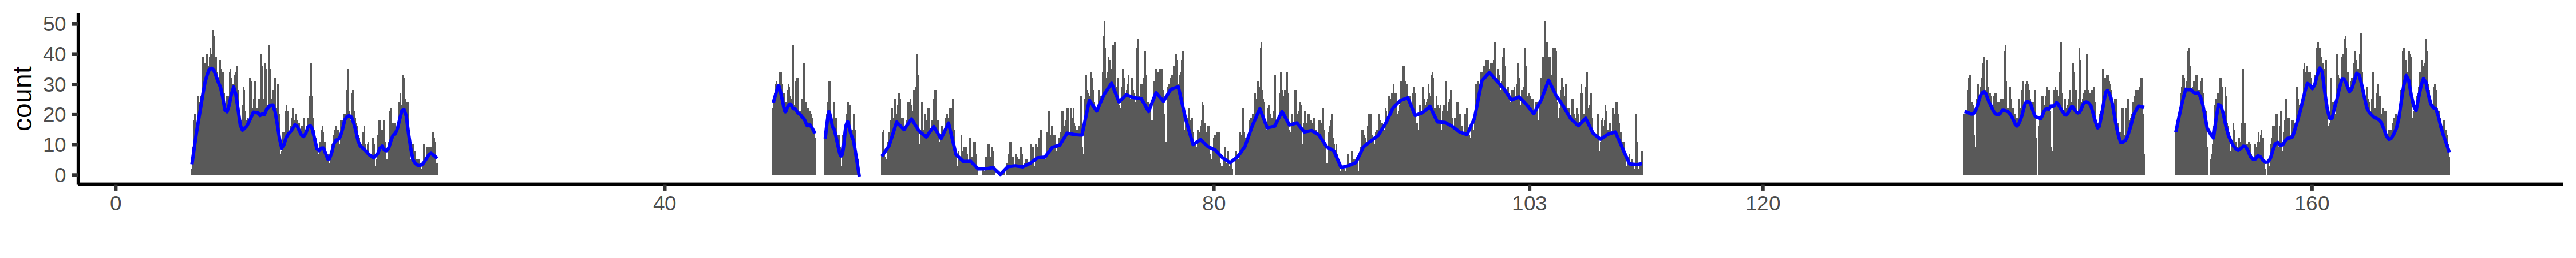

In [25]:
options(repr.plot.width = 15,repr.plot.height=1.5,repr.plot.res= 300)
ggplot() + 
  geom_col(data = DI_dec_pos_count, aes(x = pos_mb, y = count),width = 0.1) + 
  geom_line(data = plot_df, aes(x = pos1, y = value, group = group_id), color = "blue", size = 0.5) +
  scale_x_continuous(breaks = c(0, 40, 80, 103, 120, 160)) + 
  theme_classic() + 
  xlab("") + ylab("count")

In [26]:
# file_paths = "/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/HiC_analysis/compartment/cooltools_compartment/B6Xi100k_c5.cis.vecs.tsv"
file_paths = "/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/fig2/compartment/c5_200000.cis.vecs.tsv"

read_wrapper <- function(filepath) {
    read_tsv(filepath) %>% mutate(file = filepath)
}
list_of_dataframes = lapply(file_paths, read_wrapper)
compartments = bind_rows(list_of_dataframes) %>% na.omit()

New names:
* `` -> `...1`
Rows: 25778 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (1): chrom
dbl (7): ...1, start, end, weight, E1, E2, E3

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [27]:
compartments <- compartments %>% filter(chrom == "chrX(pat)") %>% select(start, end, E1) %>% mutate(compartment = ifelse(E1 >= 0, "A","B"))

In [29]:
compartments <- compartments %>% select(start, end, E1) %>% mutate(compartment = ifelse(E1>0,"A","B"))

In [30]:
blocks <- compartments %>% filter(compartment == "A")
blocks <- blocks %>% mutate(pos_diff = c(0, diff(start)))

sub_dfs <- list()
start_idx <- 1

for (idx in 1:nrow(blocks)) {
  if (blocks$pos_diff[idx] > 200000) {
    sub_dfs[[length(sub_dfs) + 1]] <- blocks[start_idx:(idx-1), ]
    start_idx <- idx
  }
}
sub_dfs[[length(sub_dfs) + 1]] <- blocks[start_idx:nrow(blocks), ]

blocks_list <- list()
for (i in seq_along(sub_dfs)) {
  sub_df <- sub_dfs[[i]]
  
  if (nrow(sub_df) >= 5) {
    block_start <- min(sub_df["start"])
    block_end <- max(sub_df["end"])
  }else{
    block_start <- -1
    block_end <- -1
  }
  
  blocks_list[[length(blocks_list)+1]] <- data.frame(start = block_start, end = block_end, group_id = i)
}

blocks_list <- do.call(rbind, blocks_list)
A_blocks <- blocks_list %>% filter(start != -1)

In [31]:
blocks <- compartments %>% filter(compartment == "B")
blocks <- blocks %>% mutate(pos_diff = c(0, diff(start)))

sub_dfs <- list()
start_idx <- 1

for (idx in 1:nrow(blocks)) {
  if (blocks$pos_diff[idx] > 200000) {
    sub_dfs[[length(sub_dfs) + 1]] <- blocks[start_idx:(idx-1), ]
    start_idx <- idx
  }
}
sub_dfs[[length(sub_dfs) + 1]] <- blocks[start_idx:nrow(blocks), ]

blocks_list <- list()
for (i in seq_along(sub_dfs)) {
  sub_df <- sub_dfs[[i]]
  
  if (nrow(sub_df) >= 5) {
    block_start <- min(sub_df["start"])
    block_end <- max(sub_df["end"])
  }else{
    block_start <- -1
    block_end <- -1
  }
  
  blocks_list[[length(blocks_list)+1]] <- data.frame(start = block_start, end = block_end, group_id = i)
}

blocks_list <- do.call(rbind, blocks_list)
B_blocks <- blocks_list %>% filter(start != -1)

In [32]:
col_range <- c(-1, 1)
line_range <- c(-55, 60)
trans_factor <- diff(col_range) / diff(line_range)

In [33]:
convert_value <- function(value) {
    (value - line_range[1]) * trans_factor + col_range[1]
}

plot_df$converted_value <- sapply(plot_df$value, convert_value)

In [34]:
compartments <- compartments %>% mutate(pos = start/1000000) %>% filter(pos %in% (mask %>% filter(type == "mapped") %>% filter(type2 == "SNPrich") %>% pull(pos))) %>% 
    filter(pos != 121.1) %>% filter(pos != 121.9)

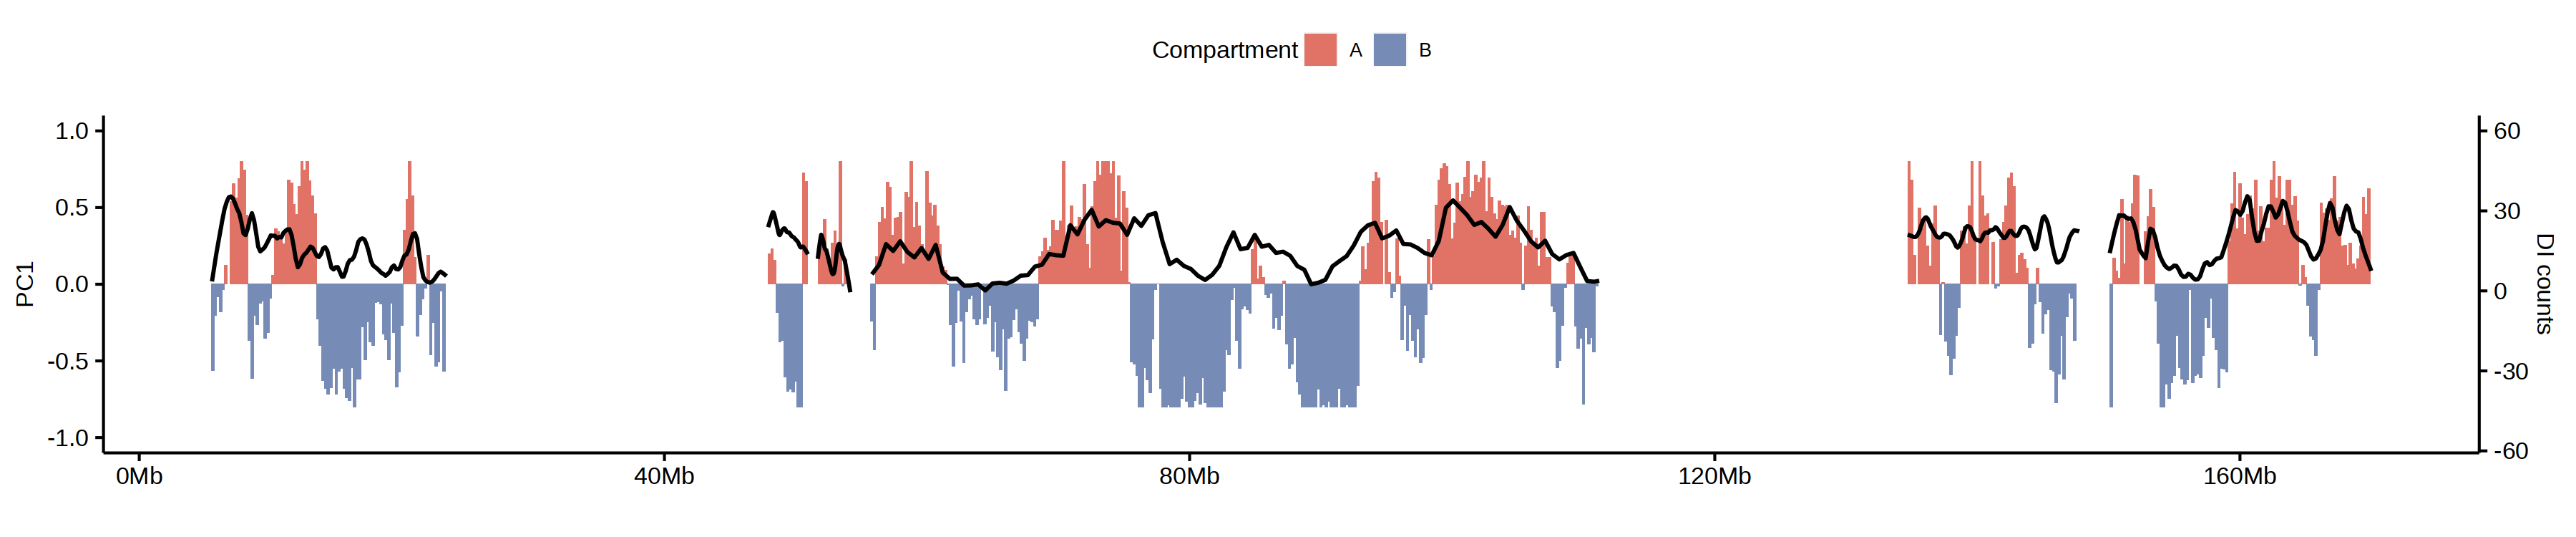

In [35]:
options(repr.plot.width = 12,repr.plot.height=2.5,repr.plot.res= 300)
library(scales)
p <- compartments %>% mutate(compartment = ifelse(E1> 0, "A","B")) %>% 
        na.omit() %>%  mutate(E1 = ifelse(E1>0.8,0.8,E1), E1 = ifelse(E1<(-0.8),-0.8,E1)) %>% mutate(start = start/1000000) %>% 
        ggplot()  +
        geom_col(aes(x=start,y=E1,fill = compartment), width = 0.2, size = 0.25) + scale_fill_manual(values=c("#e07266","#768cb6"), name = 'Compartment') +
        geom_line(data = plot_df, aes(x = pos1, y = converted_value, group = group_id), color = "black", size = 0.5) +
        xlab("") + scale_x_continuous(breaks = c(0, 40, 80, 120, 160), labels = label_number(scale = 1, suffix = "Mb")) + ylab("PC1") +
        scale_y_continuous(
        limits = col_range,  # 主轴的范围设置为 col_range
        sec.axis = sec_axis(
                trans = ~(. - col_range[1]) / trans_factor + line_range[1], 
                name = "DI counts"
        )
        )+
        theme(legend.position = "top",
                text = element_text(family="Arial", size=8),
                panel.border = element_blank(),
                panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(),
                panel.background = element_blank(),
                axis.line = element_line(color="black", linewidth = 0.35),
                axis.ticks = element_line(color="black", linewidth = 0.35),
                axis.text = element_text(color="black",size=8),
                legend.key = element_rect(colour = NA),
                axis.title=element_text(color="black",size=8,face="plain"),
                  legend.key.width = unit(0.4, "cm"),
                  legend.key.height = unit(0.4, "cm")
                ) 
p
ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3I_DI_comp_distribution.svg", width = 12, height = 2.5, units = "in", dpi = 300)

In [36]:
compartments %>% mutate(compartment = ifelse(E1> 0, "A","B")) %>% group_by(compartment) %>% summarise(count = n())

compartment,count
<chr>,<int>
A,273
B,275


In [37]:
line_range[2]

[1] 60

In [38]:
merged_df <- merged_df %>% mutate(start = floor(pos_mb * 1000000 / 200000) * 200000)%>% left_join(compartments, by = "start") %>% left_join(compartments)

Joining with `by = join_by(start, end, E1, compartment, pos)`


In [39]:
pie_plot <- merged_df %>% filter(!is.na(compartment)) %>% group_by(compartment) %>% summarise(count = sum(count)) %>% 
    mutate(count_pct = count/sum(count) * 100, label_pos = cumsum(count) - 0.5 * count)
head(pie_plot)

compartment,count,count_pct,label_pos
<chr>,<dbl>,<dbl>,<dbl>
A,59735,64.05486,29867.5
B,33521,35.94514,76495.5


In [40]:
pie_plot %>% left_join(compartments %>% group_by(compartment) %>% summarise(count_comp = n())) %>% 
    mutate(DI_count_per_100k = count/count_comp)

Joining with `by = join_by(compartment)`


compartment,count,count_pct,label_pos,count_comp,DI_count_per_100k
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
A,59735,64.05486,29867.5,273,218.8095
B,33521,35.94514,76495.5,275,121.8945


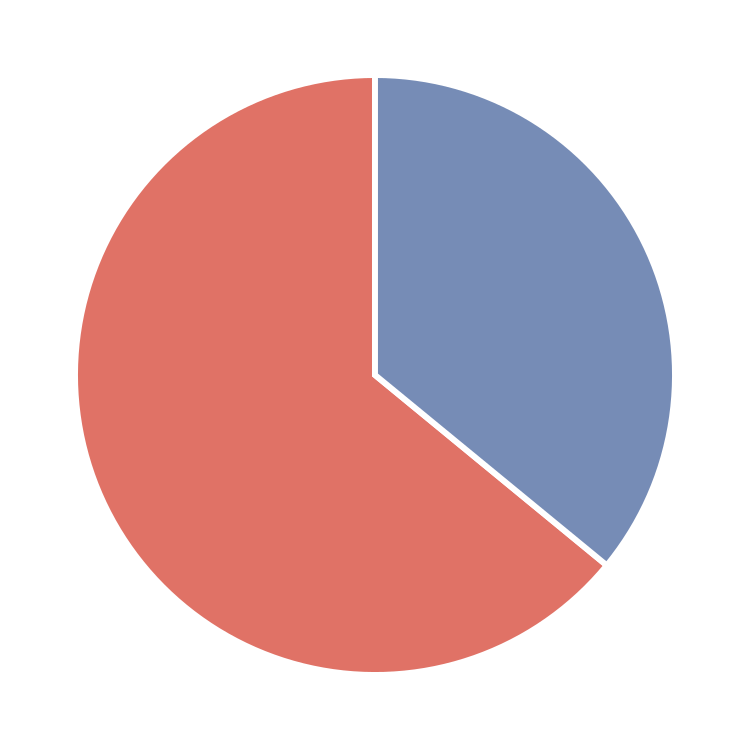

In [41]:
options(repr.plot.width = 2.5,repr.plot.height=2.5,repr.plot.res= 300)

ggplot(pie_plot, aes(x="", y=count, fill=compartment)) +
  geom_bar(stat="identity", linewidth=0.5, color="white") +
  coord_polar("y", start=0) +
  scale_fill_manual(values=c("#e07266","#768cb6")) + 
  theme_void() + theme(legend.position = "none")

ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/fig3/fig3J_DI_comp_distribution_pie.svg", width = 2.5, height = 2.5, units = "in", dpi = 300)

# escapee

In [42]:
library(readxl)

In [43]:
classification <- read_excel("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/DI/classification_gene.xlsx", sheet = "X-linked Gene Classification")

In [44]:
classification <- classification %>% select(c('Gene Symbol','Start','End','Length','Barros de Andrade e Sousa et al. 2019 [Classification: XCI/Escape]','Barros de Andrade e Sousa et al. 2019 [Classification: Sylencing Dynamics]','Borensztein et al. 2017 [Classification: Xi = B6]','Borensztein et al. 2017 [Classification: Xi = Cast]','Marks et al. 2015 [Classification: Xi = B6]'))

In [45]:
names(classification) <- c('gene','start','end','length','Barros_escapee','Barros_dynamic','Borensztein_B6','Borensztein_Cast','Marks_B6')

In [46]:
classification %>% dim()

[1] 74  9

In [47]:
classification %>% filter((Barros_escapee=="Not Silenced")|(Borensztein_B6=="Escapee")|(Marks_B6=="Escapee"))

gene,start,end,length,Barros_escapee,Barros_dynamic,Borensztein_B6,Borensztein_Cast,Marks_B6
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
Klhl13,23219271,23365082,145811,Not Silenced,NA,NA,NA,Early
Jade3,20425688,20519939,94251,Not Silenced,NA,Late,Late,Late
Dkc1,75095854,75109777,13923,Not Silenced,NA,NA,NA,Escapee
Ebp,8185329,8193512,8183,Not Silenced,NA,NA,Late,Escapee
Idh3g,73778963,73786897,7934,Not Silenced,NA,NA,Escapee,Late
Ndufb11,20615326,20617619,2293,NA,NA,Escapee,NA,NA
Nkap,37126795,37150746,23951,Not Silenced,NA,NA,Escapee,Late
Uba1,20658326,20683179,24853,Not Silenced,NA,NA,Escapee,Late
Pdha1,160122209,160138413,16204,Silenced,NA,Escapee,NA,Late


In [48]:
mean(DI_dec_pos_count$count)

[1] 17.4194

In [51]:
classification <- classification %>% mutate(start_bin = floor(start/20000), end_bin = ceiling(end/20000)) %>% mutate(length = end_bin-start_bin)

In [52]:
classification <- classification %>% filter(!is.na(start))

In [53]:
mask <- mask %>% filter(type == "mapped") %>% filter(type2 == "SNPrich") %>% mutate(bin_index = floor(pos*1000000/20000))
classification <- classification %>% filter(start_bin %in% mask$bin_index) %>% filter(end_bin %in% mask$bin_index)

In [54]:
whole_counts <- mask %>% rename(pos_mb = pos) %>% left_join(DI_dec_pos_count) %>% mutate(count = ifelse(is.na(count),0,count))

Joining with `by = join_by(pos_mb)`


In [55]:
classification%>% filter(Marks_B6 %in% c("Escapee"))

gene,start,end,length,Barros_escapee,Barros_dynamic,Borensztein_B6,Borensztein_Cast,Marks_B6,start_bin,end_bin
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Dkc1,75095854,75109777,2,Not Silenced,NA,NA,NA,Escapee,3754,3756
Utp14a,48256862,48282453,3,NA,Late,NA,Escapee,Escapee,2412,2415
Eras,7924276,7928607,1,Silenced,Early,NA,NA,Escapee,396,397
Tfe3,7762560,7775202,1,Silenced,NA,NA,Late,Escapee,388,389


In [56]:
classification%>% filter(Borensztein_B6 %in% c("Escapee"))

gene,start,end,length,Barros_escapee,Barros_dynamic,Borensztein_B6,Borensztein_Cast,Marks_B6,start_bin,end_bin
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Ndufb11,20615326,20617619,1,NA,NA,Escapee,NA,NA,1030,1031
Pdha1,160122209,160138413,1,Silenced,NA,Escapee,NA,Late,8006,8007
Pbdc1,105079756,105117090,3,Not Silenced,NA,Escapee,Escapee,Late,5253,5256
Sms,157443855,157492287,3,NA,Late,Escapee,Escapee,Intermediate,7872,7875


In [57]:
classification%>% filter(Barros_escapee %in% c("Not Silenced"))

gene,start,end,length,Barros_escapee,Barros_dynamic,Borensztein_B6,Borensztein_Cast,Marks_B6,start_bin,end_bin
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Klhl13,23219271,23365082,9,Not Silenced,NA,NA,NA,Early,1160,1169
Jade3,20425688,20519939,5,Not Silenced,NA,Late,Late,Late,1021,1026
Dkc1,75095854,75109777,2,Not Silenced,NA,NA,NA,Escapee,3754,3756
Idh3g,73778963,73786897,2,Not Silenced,NA,NA,Escapee,Late,3688,3690
Uba1,20658326,20683179,3,Not Silenced,NA,NA,Escapee,Late,1032,1035
Pbdc1,105079756,105117090,3,Not Silenced,NA,Escapee,Escapee,Late,5253,5256
Araf,20797814,20860519,5,Not Silenced,NA,NA,Escapee,Late,1039,1044
Brcc3,75416628,75454001,3,Not Silenced,NA,NA,NA,Late,3770,3773
Ftsj1,8238668,8252406,2,Not Silenced,NA,NA,NA,NA,411,413


In [58]:
get_escapee_di <- function(esc_classification,source){
    esc_di_nums <- c()
    esc_side_nums <- c()
    for (i in 1:nrow(esc_classification)){
        start_bin <- esc_classification$start_bin[i]
        end_bin <- esc_classification$end_bin[i]
        bins <- seq(start_bin,end_bin)
        # classification$counts_all[i] <- sum(pos_all$counts_all[pos_all$pos %in% bins])/length(bins)
        esc_di_num <- whole_counts$count[whole_counts$bin_index %in% bins]
        esc_di_num <- mean(esc_di_num)
        esc_di_nums <- c(esc_di_nums, esc_di_num)

        length <- end_bin - start_bin
        bins1 <- seq(start_bin - ceiling((length+1)/2), start_bin-1)
        bins2 <- seq(end_bin+1, end_bin + ceiling((length+1)/2))
        esc_side_num1 <- whole_counts$count[whole_counts$bin_index %in% bins1]
        esc_side_num2 <- whole_counts$count[whole_counts$bin_index %in% bins2]
        esc_side_num1 <- mean(esc_side_num1)
        esc_side_num2 <- mean(esc_side_num2)
        esc_side_nums <- c(esc_side_nums, esc_side_num1+esc_side_num2)
    }
    plot1 <- data.frame(di = esc_di_nums, type = "escapee")
    plot2 <- data.frame(di = esc_side_nums, type = "side")
    plot_df <- rbind(plot1,plot2) %>% mutate(source = source)
    return(plot_df)
}

In [59]:
get_escapee_comp <- function(esc_classification,source, merged_df){
    for (i in 1:nrow(esc_classification)){
        start_bin <- esc_classification$start_bin[i]
        end_bin <- esc_classification$end_bin[i]
        bins <- seq(start_bin,end_bin)
        comp_num <- merged_df %>% filter(index %in% bins) %>% 
            group_by(compartment) %>% summarise(count = n()) %>% mutate(type = 'escapee')

        length <- end_bin - start_bin
        bins1 <- seq(start_bin - ceiling((length+1)/2), start_bin-1)
        bins2 <- seq(end_bin+1, end_bin + ceiling((length+1)/2))
        comp_num1 <- merged_df %>% filter(index %in% bins1) %>%
            group_by(compartment) %>% summarise(count = n()) %>% mutate(type = 'side')
        comp_num2 <- merged_df %>% filter(index %in% bins2) %>% 
            group_by(compartment) %>% summarise(count = n()) %>% mutate(type = 'side')
        
        comp_temp <- rbind(comp_num, comp_num1, comp_num2) %>% mutate(gene = esc_classification$gene[i])
        if(i == 1){
            comp_df <- comp_temp
        }else{
            comp_df <- rbind(comp_df, comp_temp)
        }
    }
    return(comp_df)
}

In [60]:
esc_classification <- classification%>% filter(Barros_escapee %in% c("Not Silenced"))
data1 <- get_escapee_di(esc_classification, source = 'Barros_escapee')
data1_comp <- get_escapee_comp(esc_classification, source = 'Barros_escapee', merged_df)

In [61]:
data1_comp %>% group_by(type, compartment) %>% summarise(count = sum(count))

`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.


type,compartment,count
<chr>,<chr>,<int>
escapee,A,49
escapee,B,10
side,A,54
side,B,5
side,NA,5


In [62]:
esc_classification <- classification %>% filter(Borensztein_B6 %in% c("Escapee"))
data2 <- get_escapee_di(esc_classification, source = 'Borensztein_B6')
data2_comp <- get_escapee_comp(esc_classification, source = 'Borensztein_B6', merged_df)

In [63]:
data2_comp

compartment,count,type,gene
<chr>,<int>,<chr>,<chr>
A,2,escapee,Ndufb11
A,1,side,Ndufb11
A,1,side,Ndufb11
A,2,escapee,Pdha1
A,1,side,Pdha1
A,1,side,Pdha1
A,4,escapee,Pbdc1
A,2,side,Pbdc1
A,2,side,Pbdc1


In [64]:
esc_classification <- classification %>% filter(Marks_B6 %in% c("Escapee"))
data3 <- get_escapee_di(esc_classification, source = 'Marks_B6')
data3_comp <- get_escapee_comp(esc_classification, source = 'Marks_B6', merged_df)

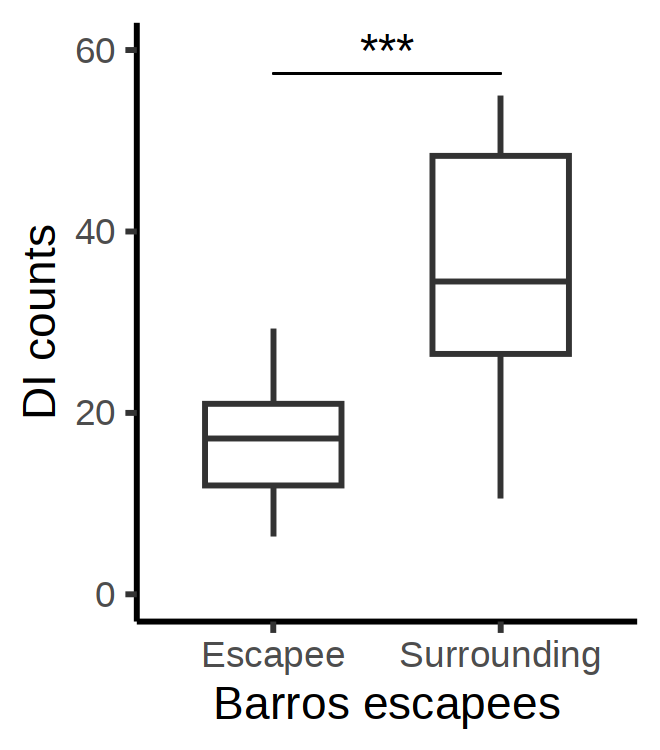

In [91]:
options(repr.plot.width = 2.2,repr.plot.height=2.5,repr.plot.res= 300)
p1 <- data1 %>%
    ggplot(aes(x = type,y = di)) + 
    geom_boxplot(fatten = 1, outlier.shape = NA, width = 0.6) + xlab("Barros escapees") + ylab("DI counts") + 
    geom_signif(test = "t.test",comparisons = list(c("escapee","side")),tip_length=0, size = 0.25, map_signif_level = TRUE, y_position = 55) +
    scale_x_discrete(labels = c("Escapee","Surrounding"))+theme_classic() + ylim(0,60)
    

p1

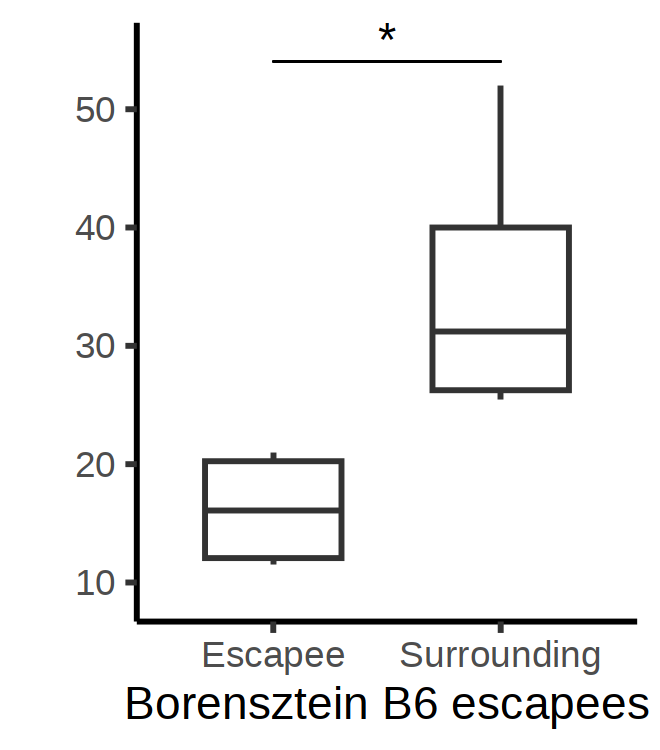

In [83]:
options(repr.plot.width = 2.2,repr.plot.height=2.5,repr.plot.res= 300)
p2 <- data2 %>%
    ggplot(aes(x = type,y = di)) + 
    geom_boxplot(fatten = 1, outlier.shape = NA, width = 0.6) + xlab("Borensztein B6 escapees") + ylab("") + 
    geom_signif(test = "t.test",comparisons = list(c("escapee","side")),tip_length=0, size = 0.25, map_signif_level = TRUE, y_position = 52) +
    scale_x_discrete(labels = c("Escapee","Surrounding"))+theme_classic() + ylim(9,55)
p2

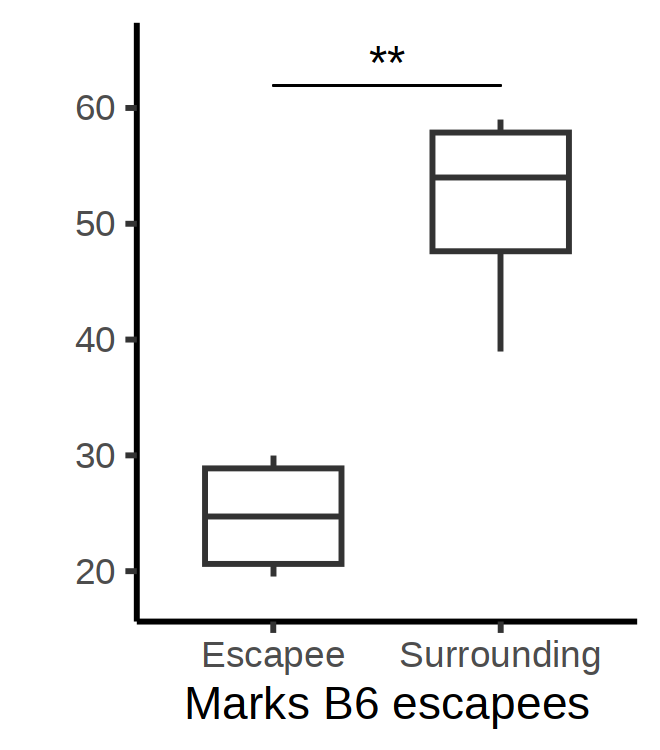

In [87]:
options(repr.plot.width = 2.2,repr.plot.height=2.5,repr.plot.res= 300)
p3 <- data3 %>%
    ggplot(aes(x = type,y = di)) + 
    geom_boxplot(fatten = 1, outlier.shape = NA, width = 0.6) + xlab("Marks B6 escapees") + ylab("") + 
    geom_signif(test = "t.test",comparisons = list(c("escapee","side")),tip_length=0, size = 0.25, map_signif_level = TRUE, y_position = 60) +
    scale_x_discrete(labels = c("Escapee","Surrounding"))+theme_classic() + ylim(18,65)
p3

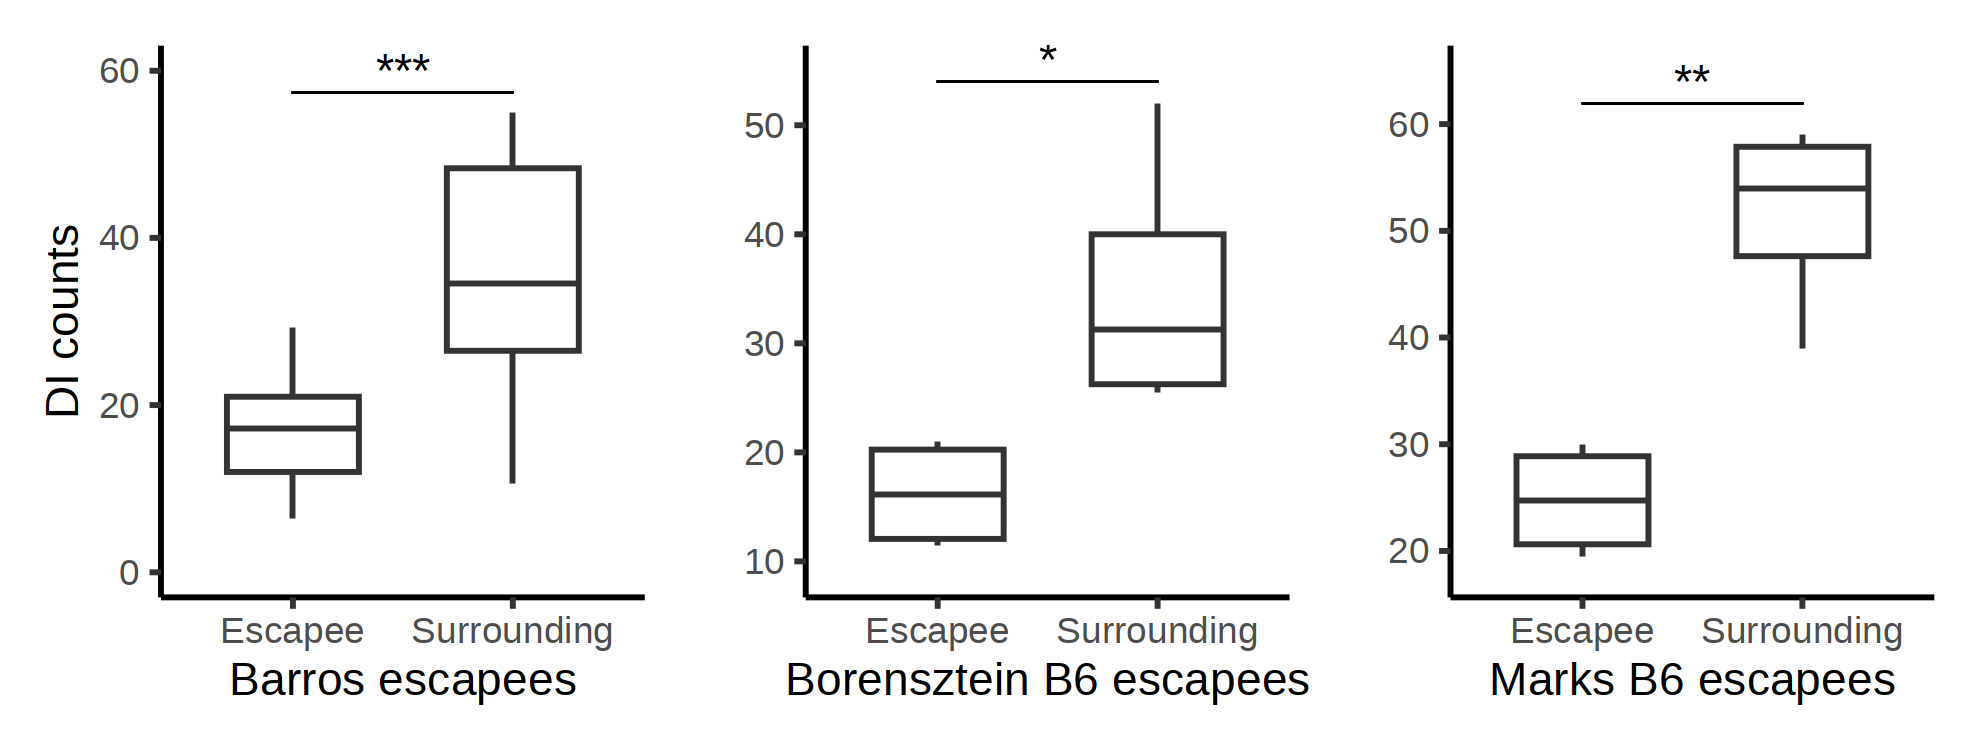

In [92]:
library(patchwork)
options(repr.plot.width = 6.6,repr.plot.height=2.5,repr.plot.res= 300)
p1 + p2 + p3
ggsave("/share/Data/hxie/project/202209/esc_xwliu/figures_0827/supp/fig4D_escapee_DI_boxplot.svg", width = 6.6, height = 2.5, units = "in", dpi = 300)